---
# Spelling Corrector

---



***Motivation:*** Checking the spelling of words in the text is the most basic requirement in any text processing/analysis task. Thus, developing a simple language model that checks the correctness of the word's spelling and suggests possible alternatives is a good starting point.

In [ ]:
import numpy as np
import re #for regular expression
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline 

### Language Model P(c)
---
In a given text, we can find the probability of occurence of each word. 

Formally, P(c) gives the probability of word c appearing in the text.

In [ ]:
def tokens(text): 
  return re.findall(r'\w+', text.lower())

def p(word, word_count):
  total_words = sum(word_count.values()) 
  return word_count[word] / total_words

After reading the file, we need to extract the words while ignoring punctuations, thus we make use of regular expression. The regex '\w+' extracts alphanumeric as well as underscore strings.

In [ ]:
words = Counter(tokens(open('sample.txt').read()))
print("There are a total of ", sum(words.values()), ' words out of which ', len(words),\
      ' are unique words.')

There are a total of  1115585  words out of which  32198  are unique words.


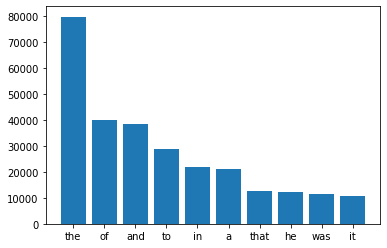

In [ ]:
labels, values = zip(*words.most_common(10))

indexes = np.arange(len(labels))

plt.bar(indexes, values,)
plt.xticks(indexes, labels)
plt.show()

The most commmon word is 'the' appearing ~ 80k times.

### Candidate Model 
---
Misspelled words often look similar to the correct word with a few errors such as missed characters, extra characters etc. The objective is to find the most likely spelling correct of a word w. Thus, we need to find correction c out of all candidate corrections such that it mazimizes the probability that c is the correction.

These candidates are generated using the distance measure, edit distance to model the different type of spelling errors. Here, we use **simple edit** which deletes, transposes, replaces and insrts to generate candidate set.

In [ ]:
def simpleEdit(word):
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes    = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts    = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

The candidate set generated is usually very large as for each word there are 54n + 25 candidates, where n is the length of the word. There might be duplicates.

For example, when w = 'doble', n = 4, thus, the upperbound on size of set is 295.

In [ ]:
print("The length of the candidate set", len(simpleEdit('doble')))

The length of the candidate set 286


Now, a lot of the words generated in the candidate set won't be present in our dictionary, thus we can eliminate those to reduce the size of our candidate set.

In [ ]:
def known(words_list):
  return(set(w for w in words_list if w in words ))

known((simpleEdit('doble')))

{'dole', 'double', 'doyle', 'noble'}

In the primary generation of candidate, we used 1 distance difference. Now, lets increase the number of edits to **two simple edit**.

In [ ]:
def twoEdits(word):
  return set([e2 for e1 in simpleEdit(word) for e2 in simpleEdit(e1)])

The length of this candidate set will be even larger but we will again use only those words which exist in our dictionary.

In [ ]:
print("The length of the candidate set", len(twoEdits('doble')))
known(twoEdits('doble'))

The length of the candidate set 36860


{'able',
 'amble',
 'bible',
 'cable',
 'dale',
 'diable',
 'dobroe',
 'dodge',
 'doe',
 'dole',
 'doled',
 'doles',
 'doll',
 'dolls',
 'dome',
 'done',
 'donne',
 'dose',
 'double',
 'doubled',
 'doubles',
 'doubly',
 'doute',
 'dove',
 'doyle',
 'doze',
 'fable',
 'gobble',
 'hole',
 'mobile',
 'mole',
 'molle',
 'noble',
 'nobler',
 'nobles',
 'ole',
 'pole',
 'robe',
 'role',
 'ruble',
 'sable',
 'sole',
 'table'}

### Error Model P(w|c)
---

The error model states that smaller the edit distance, smaller the error. all known words with edit distance 1 are more probable than the those which are 2 edit distance away. However the highest priority is given to known word with 0 edit distance.

For more detail refer [here.](https://norvig.com/spell-correct.html)

In [ ]:
def correct(word): 
  candidates = known([word]) or known(simpleEdit(word)) or known(twoEdits(word)) or [word]
  return max(candidates, key=words.get)

### Evaluation

---

In [ ]:
list(map(correct, tokens('Speling errurs in somethink. Whutever; unusuel misteakes everyware?')))

['spelling',
 'errors',
 'in',
 'something',
 'whatever',
 'unusual',
 'mistakes',
 'everywhere']

We evaluate the performance of our model against a spelling error corpus. 

In [ ]:
def spelltest(tests, verbose=False):
    import time
    start = time.clock()
    good, unknown = 0, 0
    n = len(tests)
    for right, wrong in tests:
        w = correction(wrong)
        good += (w == right)
        if w != right:
            unknown += (right not in words)
            if verbose:
                print('correction({}) => {} ({}); expected {} ({})'\
                      .format(wrong, w, words[w], right, words[right]))
    dt = time.clock() - start
    print('{:.0%} of {} correct ({:.0%} unknown) at {:.0f} words per second '\
          .format(good / n, n, unknown / n, n / dt))
    
def Testset(lines):
    return [(right, wrong)
            for (right, wrongs) in (line.split(':') for line in lines)
            for wrong in wrongs.split()]

spelltest(Testset(open('test1.txt'))) # Development set
spelltest(Testset(open('test2.txt'))) # Final test set


75% of 270 correct at 40 words per second
69% of 400 correct at 32 words per second
